## Uso del Weighted Adder de Qiskit

r"""A circuit to compute the weighted sum of qubit registers.
    Given $ \pmb{n} $  qubit basis states $ \pmb{q_0, \ldots, q_{n-1} \in \{0, 1\}} $ and non-negative
    integer weights $  \pmb{\lambda_0, \ldots, \lambda_{n-1} } $ , this circuit performs the operation

$$
        |q_0 \ldots q_{n-1}\rangle |0\rangle_s
        \mapsto |q_0 \ldots q_{n-1}\rangle |\sum_{j=0}^{n-1} \lambda_j q_j\rangle_s
$$

Where $ \pmb {s }$ is the number of sum qubits required.

This can be computed as:

$$
        s = 1 + \left \lfloor \log_2 \left( \sum_{j=0}^{n-1} \lambda_j \right) \right\rfloor
$$ 
    

or $ s = 1 $ if the sum of the weights is 0 (then the expression in the logarithm is invalid).
    
For qubits in a circuit diagram, the first weight applies to the upper-most qubit.
For an example where the state of 4 qubits is added into a sum register, the circuit can be schematically drawn as:
  

                   ┌────────┐
          state_0: ┤0       ├ | state_0 * weights[0]
                   │        │ |
          state_1: ┤1       ├ | + state_1 * weights[1]
                   │        │ |
          state_2: ┤2       ├ | + state_2 * weights[2]
                   │        │ |
          state_3: ┤3       ├ | + state_3 * weights[3]
                   │        │
            sum_0: ┤4       ├ |
                   │  Adder │ |
            sum_1: ┤5       ├ | = sum_0 * 2^0 + sum_1 * 2^1 + sum_2 * 2^2
                   │        │ |
            sum_2: ┤6       ├ |
                   │        │
          carry_0: ┤7       ├
                   │        │
          carry_1: ┤8       ├
                   │        │
        control_0: ┤9       ├
                   └────────┘


In [1]:
from qiskit.circuit.library import WeightedAdder

In [2]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

#### Se Carga la cuenta para poder realizar las simulaciones
#IBMQ.load_account()
###

%matplotlib inline
# Librerías estandar de Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import *

#Librería para optimizar el circuito que se diseñe
from qiskit.compiler import transpile, assemble

#Librerias para el trabajo en el dispositivo real
from qiskit.tools.monitor import job_monitor
from qiskit import IBMQ

#Librerias para la visualización por medio de la esfera de Bloch y de histogramas
from qiskit.tools.visualization import plot_bloch_multivector
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.visualization import plot_state_city

## Librerías para la visualización de Vectores y matrices
###Display usando markdown
import numpy as np
from IPython.display import display, Markdown, Latex
from array_to_latex import to_ltx
###Otros Display
from herramientas.tools import vector2latex
from herramientas.learn_quantum import format_state_vector
from herramientas.learn_quantum import print_short_state_vector
from herramientas.tools import unitary2latex

from herramientas.tools import unitary2latex2 #Funcion creada para poder visualizar la parte imaginaria

## Se configura la forma de visualizar los vectores con el uso latex y markdown
latex_formatter = get_ipython().display_formatter.formatters["text/latex"]
latex_formatter.for_type(np.ndarray, lambda m: to_ltx(m, print_out=False))

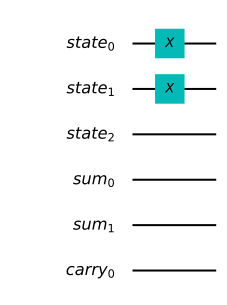

In [3]:
state = QuantumRegister(3,name= 'state')
sum = QuantumRegister(2,name= 'sum')
carry = QuantumRegister(1,name= 'carry')
qc=QuantumCircuit(state,sum,carry)
qc.x(state[0])
qc.x(state[1])
qc.draw(output='mpl')

### para comparar las matrices numpy.allclose(A,Q)

In [4]:
x=WeightedAdder(num_state_qubits=3, name= 'Wadd')

In [5]:
x.draw()

»
state_0: ──■────■────■─────────■───────────────────────────────────────────────»
           │    │    │         │                                               »
state_1: ──┼────┼────┼─────────┼─────────■────■────■─────────■─────────────────»
           │    │    │         │         │    │    │         │                 »
state_2: ──┼────┼────┼─────────┼─────────┼────┼────┼─────────┼─────────■────■──»
           │  ┌─┴─┐  │  ┌───┐  │  ┌───┐  │  ┌─┴─┐  │  ┌───┐  │  ┌───┐  │  ┌─┴─┐»
  sum_0: ──■──┤ X ├──┼──┤ X ├──■──┤ X ├──■──┤ X ├──┼──┤ X ├──■──┤ X ├──■──┤ X ├»
           │  └───┘┌─┴─┐└───┘  │  └───┘  │  └───┘┌─┴─┐└───┘  │  └───┘  │  └───┘»
  sum_1: ──┼───────┤ X ├───────┼─────────┼───────┤ X ├───────┼─────────┼───────»
         ┌─┴─┐     └─┬─┘     ┌─┴─┐     ┌─┴─┐     └─┬─┘     ┌─┴─┐     ┌─┴─┐     »
carry_0: ┤ X ├───────■───────┤ X ├─────┤ X ├───────■───────┤ X ├─────┤ X ├─────»
         └───┘               └───┘     └───┘               └───┘     └───┘     »
«                             
«state_0: ────────────────────
«                             
«state_1: ────────────────────
«                             
«state_2: ──■─────────■───────
«           │  ┌───┐  │  ┌───┐
«  sum_0: ──┼──┤ X ├──■──┤ X ├
«         ┌─┴─┐└───┘  │  └───┘
«  sum_1: ┤ X ├───────┼───────
«         └─┬─┘     ┌─┴─┐     
«carry_0: ──■───────┤ X ├─────
«                   └───┘

In [6]:
sup=QuantumCircuit(state,sum,carry)
sup=qc+x

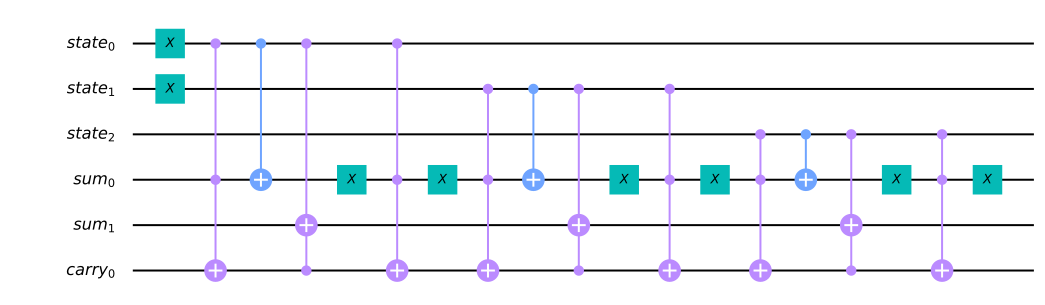

In [7]:
sup.draw(output='mpl')